# NER experiments

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from text_processing import process_text
from constants import PROCESSED_DATA_PATH
from utils import load_pickle_file
from detectors import *
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from ipywidgets import interact
import ipywidgets as widgets

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.options.display.max_colwidth = 1600

In [4]:
_ = torch.manual_seed(1)

In [5]:
EMBEDDING_DIM = 32
HIDDEN_DIM = 32
N_TRAINING = 5000
EPOCHS = 15
TECHNOLOGY_MARK = '*T*'

## Load data

In [6]:
processed_data = load_pickle_file(PROCESSED_DATA_PATH)
job_summary_list = processed_data['job_summary_list']
documents = processed_data['documents']
lemmas = processed_data['lemmas']
df_data = processed_data['df_processed']

In [7]:
df_data.head()

,id,categories__name,date_published,employer__name,is_active,job_description,job_title__name,location__name,location__population,pages__name,language,job_summary
0,1,"[python, RPA]",2018-06-22,Veikkaus Oy,False,"Veikkaus on suomalaisten omistama peliyhtiö. Tuotamme yli miljardi euroa vuodessa yhteiseen hyvään. Rahapelejämme pelaavat lähes kaikki aikuiset suomalaiset, ja meillä on yli kaksi miljoonaa etuasiakasta. Haluamme, että pelejämme pelataan turvallisesti ja maltilla.\nTyöllistämme lähes 2 000 eri alojen ammattilaista. Meillä työskentelee uusien hittipelien kehittäjiä, digi- ja datavelhoja sekä ICT-alan huippuammattilaisia. Asiakaspalvelun taitajia kohtaat puhelin- ja chat-palvelussamme sekä maanlaajuisesti Pelaamoissa, Feel Vegaseissa, ravintolapelipöydissä ja Suomen ainoalla kasinolla Helsingissä.\n\nOletko kiinnostunut eturintaman paikasta suomalaisessa pelimaailmassa? Kiinnostaako työskentely suuressa suomalaisessa softatalossa? Haluatko laajentaa automaatio-osaamistasi monipuolisessa työskentely-ympäristössä?\n\nYhdistämme Veikkauksessa testausautomaation ja ohjelmistorobotiikan uniikilla tavalla. Meillä Veikkauksessa testausautomaatiota on kaikkialla: peleissä, pelialustoissa sekä taustajärjestelmissä. Ohjelmistorobotiikan (RPA) saralla toiminta on kasvamassa kovaa vauhtia.\n\nVeikkaus etsii Automaatioasiantuntijaa\nvakituiseen työsuhteeseen.\n\nAutomaatioasiantuntijamme kehittävät ja ylläpitävät automaatioympäristöjä sekä luovat ja ylläpitävät testausautomaatiota laatuasiantuntijoidemme ja kehittäjien tueksi. Lisäksi tiimin vastuulle kuuluu Veikkauksen ohjelmistorobotiikkaratkaisujen kehittäminen ja ylläpito. Optimaalinen hakija on laatuorientoitunut tiimipelaaja, jolla on oma-aloitteinen ote automaatioratkaisujen kehittämisessä. Intohimo ensiluokkaiseen laatuun on ...",Testausautomaation ja RPA:n asiantuntija,Helsinki,645482.0,Indeed,fi,Testausautomaation ja RPA:n asiantuntija | Veikkaus Oy | Helsinki
1,2,RPA,2018-06-22,Nordea,False,"We are looking for Insurance Professional´s. You will meet our customers’ changing needs and offer them the best possible service.\n\nIn today’s world, change is the one thing you can count on. But whatever the future brings, our customers remain at the heart of everything we do.\n\nThat’s where you come in. Working with dedicated colleagues in an exciting, fast-paced environment, you’ll help meet our customers’ changing needs.\n\nWe aim to be courageous and explorative in our approach to innovating better ways of delivering banking services – anytime, anywhere. This means you’ll have many opportunities to learn and grow as you build your career with us. Will you help us lead the way in creating great customer experiences?\n\nYour future responsibilities\nYou will join Nordea Life´s Customer Services unit. Nordea Life is a subsidiary to Nordea. We offer life insurance solutions to private and corporate customers. Our mission is to integrate our products with those of Nordea bank and make life insurances more accessible for the customers.\n\nWe are around 160 life business professionals. We continuously develop our way of working to be able to take customer satisfaction to the next level. We offer you an interesting and challenging position that enables you to show your potential and to grow professionall.\n\nNordea Life is Great Place to Work® listed company in Finland 2017 and 2018. In the last survey 95 percent of our employees say their workplace is great.\n\nWhat you’ll be doing:\n\nProviding excellent customer service in different channels\nShowing flexibility and ...","Insurance Professional, Helsinki",Helsinki,645482.0,Indeed,en,"Insurance Professional, Helsinki | Nordea | Helsinki"
2,3,RPA,2018-06-20,Nordea,False,"It’s an exciting time for you to join us. We’re a changing company with big ambitions and together we’ll create the future of banking.\n\nWorking with us, you will play a part in building a better bank that fulfils a meaningful role in society. We aim to help our cus

## Labeling

In [8]:
def highlight_words(text, words, color):
    for word in words:
        text = text.replace(word, f'<font color="{color}">{word}</font>')
    return text

In [9]:
labeled_job_descriptions, labels = [], []
for index, row in df_data.iterrows():
    features = detect_technology_features(row.job_description)
    job_description_labeled = row.job_description
    for feature in features:
        job_description_labeled = job_description_labeled.replace(feature, f'{feature}{TECHNOLOGY_MARK}')
    labeled_job_descriptions.append(job_description_labeled)
    labels.append(features)
    
df_data['labeled_job_description'] = labeled_job_descriptions
df_data['labels'] = labels

In [10]:
index = -1
doc = df_data.iloc[index].job_description
labels = df_data.iloc[index].labels
text_highlighted = highlight_words(doc, labels, 'red')
display(HTML(text_highlighted))

In [11]:
@interact(index=widgets.IntSlider(min=0, max=df_data.shape[0]-1, step=1, value=0))
def show_labeled_doc(index=0):
    data = df_data.iloc[index]
    doc = data.job_description
    labels = data.labels
    title = f'{data.job_title__name} ({data.employer__name})'
    text_highlighted = highlight_words(doc, labels, 'red')
    print(f'{title}')
    display(HTML(text_highlighted))
    print(f'Labels: {labels}')

interactive(children=(IntSlider(value=0, description='index', max=6658), Output()), _dom_classes=('widget-inte…

## Prepare data

In [12]:
labeled_data = []
for doc in df_data.labeled_job_description:
    sentences = doc.split('.')
    for sentence in sentences:
        words = sentence.split()
        x, y = [], []
        for word in words:
            if TECHNOLOGY_MARK in word:
                y.append('T')
                x.append(word.replace(TECHNOLOGY_MARK, ''))
            else:
                y.append('O')
                x.append(word)
        if not x: 
            break
        labeled_data.append((x,y))

In [13]:
word_to_ix = {}
for sent, tags in labeled_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

In [14]:
tag_to_ix = {"O": 0, "T": 1}

In [15]:
training_data = labeled_data[:N_TRAINING]
validation_data = labeled_data[N_TRAINING:]

## LSTM model

In [16]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

## Train model

In [17]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [18]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [19]:
losses_per_epoch = []
for epoch in range(EPOCHS):
    losses = []
    for i, (sentence, tags) in enumerate(training_data):
        
        clear_output(wait=True)
        print(f'Epoch {epoch}/{EPOCHS}: {i}/{len(training_data)}', end='', flush=True)
        
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
        tag_scores = model(sentence_in)

        model.zero_grad()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
    mean_loss = np.mean(losses)
    losses_per_epoch.append(mean_loss)
    print(f'Loss: {mean_loss}')

Epoch 14/15: 4999/5000Loss: 0.0013853420230348508


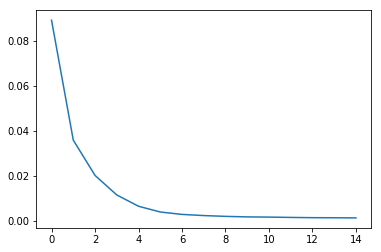

In [20]:
plt.plot(losses_per_epoch)

## Test model

In [21]:
def colorify(word, relevance):
    r = 255
    g = 255 - relevance*2
    b = 255 - relevance*2
    color = '#%02x%02x%02x' % (r,g,b)
    return f'<span style="background-color:{color}">{word}</span>'

In [22]:
def colorify_sentences(sentences):
    colorifed_data = []
    for sentence in sentences:
        with torch.no_grad():
            inputs = prepare_sequence(sentence, word_to_ix)
            tag_scores = model(inputs)
        relevances = 100*torch.exp(tag_scores).detach().numpy()[:,1]
        relevances = relevances.astype(int)
        colorifed = [colorify(w,r) for w,r in zip(sentence, relevances)]
        colorifed_data += colorifed
    return colorifed_data

### Test with training data

In [23]:
test_sentences = [item[0] for item in training_data[0:1000]]
colorifed_data = colorify_sentences(test_sentences)
HTML(" ".join(colorifed_data))

### Test with validation data

In [24]:
test_sentences = [item[0] for item in validation_data[0:1000]]
colorifed_data = colorify_sentences(test_sentences)
HTML(" ".join(colorifed_data))